In [1]:
import mphot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
instrument_efficiency_path = '../resources/systems/speculoos_Andor_iKon-L-936_-60.csv' # index in microns, efficiency of telescope+instrument as fraction
filter_path = '../resources/filters/I+z.csv' # index in microns, filter efficiency as fraction

name, system_response = mphot.generate_system_response(instrument_efficiency_path, filter_path)

`/Users/peter/Github/mphot/src/mphot/datafiles/system_responses/speculoos_Andor_iKon-L-936_-60_I+z_instrument_system_response.csv` has been generated and saved!


<Axes: title={'center': 'speculoos_Andor_iKon-L-936_-60_I+z'}, xlabel='Wavelength (microns)', ylabel='System Response'>

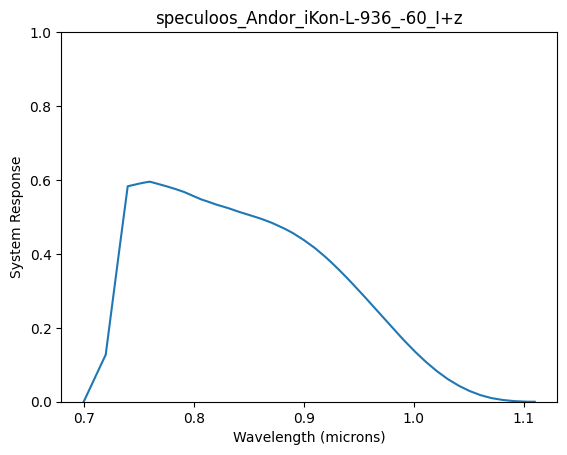

In [3]:
system_response.plot(xlabel='Wavelength (microns)', ylabel='System Response', title=name, ylim=(0, 1))

In [4]:
# sky properties
props_sky = {
    "pwv" : 2.5,        # PWV [mm]
    "airmass" : 1.1,    # airmass
    "seeing" : 1.35     # seeing (==FWHM) ["]
}

# instrument properties
props_instrument = {
    "name" : name,          # name to get SR/precision grid from file
    "plate_scale" : 0.35,   # pixel plate scale ["]
    "N_dc" : 0.2,           # dark current [e/pix/s]
    "N_rn" : 6.328,         # read noise [e_rms/pix]
    "well_depth" : 64000,   # well depth [e/pix]
    "well_fill" : 0.7,      # fractional value to fill central target pixel, assuming gaussian (width function of seeing^)
    "read_time" : 10.5,     # read time between images [s]
    "r0" : 0.5,             # radius of telescope's primary mirror [m]
    "r1" : 0.14,            # radius of telescope's secondary mirror [m]
    # "min_exp" : 0,          # optional, minimum exposure time [s]
    # "max_exp" : 120,        # optional, maximum exposure time [s]
    # "ap_rad" : 3            # optional, aperture radius [FWHM, seeing] for photometry -- 3 default == 7 sigma of Gaussian
}

# target properties
Teff = 2566       # [K]
distance = 12.5   # [pc]


In [5]:
# get the precision and components used to calculate it (generates grid if not already present)
result = mphot.get_precision(props_instrument, props_sky, Teff, distance)

mphot.display_results(result)

,single frame [ppt],10 minute binned [ppt]
,speculoos_Andor_iKon-L-936_-60_I+z,speculoos_Andor_iKon-L-936_-60_I+z
All,1.50,0.537
Star,1.14,0.409
Scintillation,0.516,0.184
Sky,0.802,0.286
Dark current,0.0977,0.0349
Read noise,0.170,0.0608


,speculoos_Andor_iKon-L-936_-60_I+z
Teff [K],2.57e+3
distance [pc],12.5
N_star [e/s],1.16e+4
star_flux [e/m2/s],1.77e+4
scn [e_rms],394
pixels in aperture [pix],421
ap_radius [pix],11.6
N_sky [e/pix/s],13.5
sky_radiance [e/m2/arcsec2/s],152
seeing [arcsec],1.35


,speculoos_Andor_iKon-L-936_-60_I+z
star [mag],13.7
sky [mag/arcsec2],18.8
vega_flux [e/s],3.64e+9


In [6]:
image_precision, binned_precision, components = result

exp_time = components["t [s]"]
base_N_star = components["N_star [e/s]"]

flux_factor = np.logspace(-2, 2, 100)
N_stars = [base_N_star * i for i in flux_factor]

precision_array = []
flux_array = []

for i in N_stars:
    image_precision_i, binned_precision_i, components_i = mphot.get_precision(props_instrument, props_sky, Teff, distance, exp_time=exp_time, N_star=i)
    
    precision_array.append(binned_precision_i)
    flux_array.append(components_i['N_star [e/s]'])

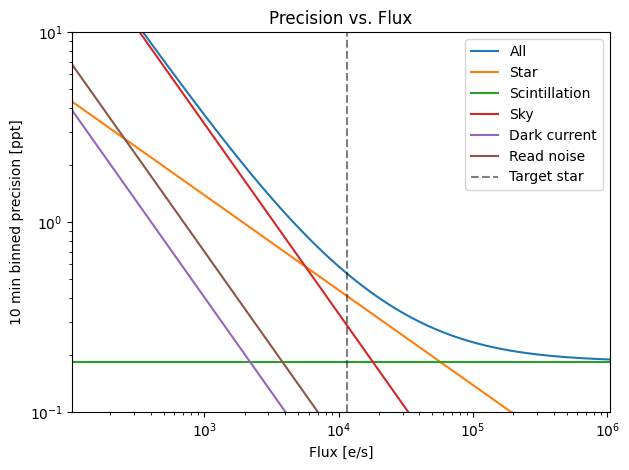

In [7]:
fig, ax = plt.subplots()

precision_df = pd.DataFrame(precision_array, index=flux_array)*1000
precision_df.plot(logy=True, logx=True, ax=ax, legend=True)

ax.axvline(components['N_star [e/s]'], linestyle='--', color='k', alpha=0.5, label='Target star')

ax.set_xlim(min(flux_array), max(flux_array))
ax.set_ylim(0.1,10)
ax.minorticks_on()


ax.set_xlabel('Flux [e/s]')
ax.set_ylabel(f"{components['binning [mins]']} min binned precision [ppt]")
ax.set_title("Precision vs. Flux")

ax.legend()

plt.tight_layout()